In [1]:
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim
import matplotlib.pyplot as plt 

In [2]:
# smapling parameters 
number_of_smaples = 100
lenght_of_sample = 1000
width_of_wave = 20

# generating sine wave samples
data = np.empty((number_of_smaples, lenght_of_sample), np.float32)

data[:] = np.array(range(lenght_of_sample)) + np.random.randint(-4*width_of_wave, 4*width_of_wave, number_of_smaples).reshape(number_of_smaples,1)

labels = np.sin(data/1.0/width_of_wave).astype(np.float32)


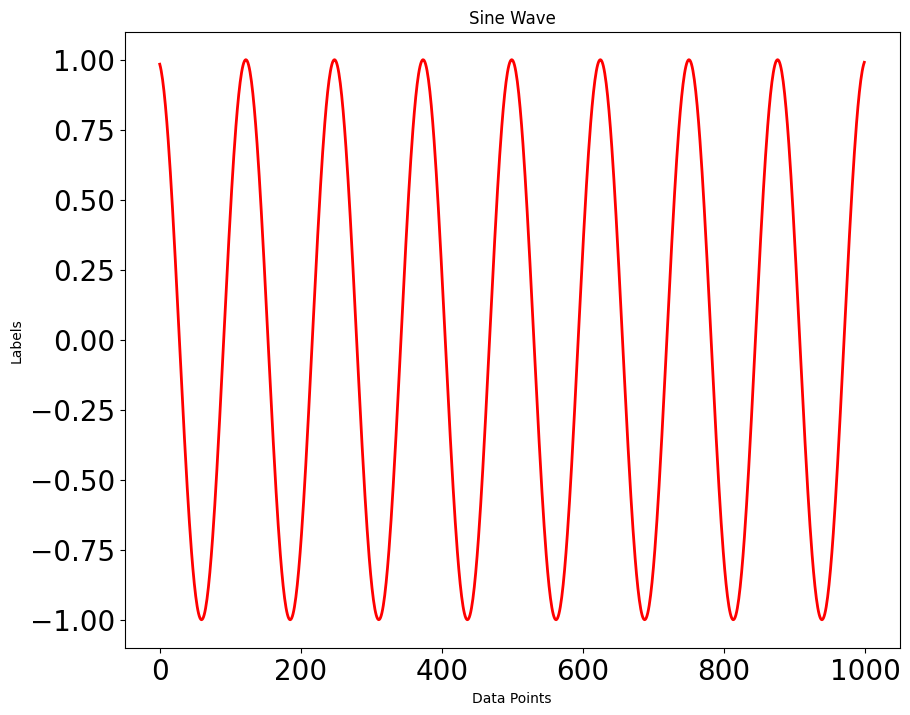

In [3]:
plt.figure(figsize=(10, 8))
plt.title("Sine Wave")
plt.xlabel("Data Points")
plt.ylabel("Labels")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(np.arange(data.shape[1]), labels[0,:],'r', linewidth=2.0)

In [4]:
class LSTMTimeSeriesPrediction(nn.Module):
    def __init__(self, hidden_size):
        super(LSTMTimeSeriesPrediction, self).__init__()
        self.hidden_size = hidden_size

        ### creating two LSTM cells and one linear layer
        self.LSTM_layer_1 = nn.LSTMCell(1, self.hidden_size)
        self.LSTM_layer_2 = nn.LSTMCell(self.hidden_size, self.hidden_size)

        # For prediction
        self.linear = nn.Linear(self.hidden_size, 1)
    
    def forward(self,data, future=0):
        outputs_list = [] 
        number_of_smaples = data.size(0)

        intial_hidden_state = torch.zeros(number_of_smaples, self.hidden_size, dtype=torch.float32)
        LSTM_layer_1_hidden = torch.zeros(number_of_smaples, self.hidden_size, dtype=torch.float32)
        LSTM_layer_1_cell = torch.zeros(number_of_smaples, self.hidden_size, dtype=torch.float32)
        LSTM_layer_2_hidden = torch.zeros(number_of_smaples, self.hidden_size, dtype=torch.float32)
        LSTM_layer_2_cell = torch.zeros(number_of_smaples, self.hidden_size, dtype=torch.float32)
        
        for instance in data.split(1, dim=1):
            LSTM_layer_1_hidden, LSTM_layer_1_cell = self.LSTM_layer_1(instance, (intial_hidden_state, LSTM_layer_1_cell))
            LSTM_layer_2_hidden, LSTM_layer_2_cell = self.LSTM_layer_2(LSTM_layer_1_hidden, (LSTM_layer_2_hidden, LSTM_layer_2_cell))

            instance_output = self.linear(LSTM_layer_2_hidden)
            outputs_list.append(instance_output)

        for furtur_instacne in range(future):
            LSTM_layer_1_hidden, LSTM_layer_1_cell = self.LSTM_layer_1(instance_output, (intial_hidden_state, LSTM_layer_1_cell))
            LSTM_layer_2_hidden, LSTM_layer_2_cell = self.LSTM_layer_2(LSTM_layer_1_hidden, (LSTM_layer_2_hidden, LSTM_layer_2_cell))
            furtur_instacne_output = self.linear(LSTM_layer_2_hidden)
            outputs_list.append(furtur_instacne_output)
        
        # concating the outputs  
        all_outputs = torch.cat(outputs_list, dim=1)
        return all_outputs



In [8]:
#Evaluating Model
if __name__ == "__main__":

    #Generating training and testing samples
    # labels = 100, 1000
    training_inputs = torch.from_numpy(labels[3:, :-1])
    training_targets = torch.from_numpy(labels[3:, 1:])

    testing_inputs = torch.from_numpy(labels[:3, :-1])
    testing_targets = torch.from_numpy(labels[:3, 1:])


    # tuneable parameter
    hidden_size = 51

    model = LSTMTimeSeriesPrediction(hidden_size)
    criterion = nn.MSELoss()
    optimizer = optim.LBFGS(model.parameters(), lr=0.8)

    # three folds
    number_of_steps = 3

    # Start Training
    for i in range(number_of_steps):
        print("Step", i)
        print("------------")

        def closure():
            optimizer.zero_grad()
            output = model(training_inputs)
            loss = criterion(output, training_targets)
            print("Training Loss", loss.item())
            loss.backward()
            return loss
    
        optimizer.step(closure)

        #  # Start Prediction/Testing, no need to track gradient here
        with torch.no_grad():
            future = 1000
            prediction = model(testing_inputs, future=future)
            loss = criterion(prediction[:, :-future], testing_targets)
            print(".....")
            print("Testing Loss", loss.item())
            print("\n")



Step 0
------------
Training Loss 0.5261120796203613
Training Loss 0.5112348794937134
Training Loss 0.4897286891937256
Training Loss 0.48026514053344727
Training Loss 0.44837644696235657
Training Loss 0.3104105591773987
Training Loss 0.24438917636871338
Training Loss 0.05094194784760475
Training Loss 0.02275482378900051
Training Loss 0.018197977915406227
Training Loss 0.017369678243994713
Training Loss 0.017035389319062233
Training Loss 0.015940025448799133
Training Loss 0.01391952857375145
Training Loss 0.010174262337386608
Training Loss 0.0059000058099627495
Training Loss 0.004804135765880346
Training Loss 0.004699320998042822
Training Loss 0.004530191421508789
Training Loss 0.004150029271841049
.....
Testing Loss 0.0037889680825173855


Step 1
------------
Training Loss 0.0036541041918098927
Training Loss 0.0028910739347338676
Training Loss 0.0023103374987840652
Training Loss 0.0018560130847617984
Training Loss 0.0016995081678032875
Training Loss 0.001602724427357316
Training Loss 0